In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
zip_path = "/content/drive/MyDrive/Nursing Home Chain Performance Measures.zip"

In [4]:
import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/Nursing_Home_Chain_Performance")


In [5]:
import os

for root, dirs, files in os.walk("/content/drive/MyDrive/Nursing_Home_Chain_Performance"):
    for file in files:
        if file.endswith(".csv"):
            print(os.path.join(root, file))


/content/drive/MyDrive/Nursing_Home_Chain_Performance/Nursing Home Chain Performance Measures/2025-11/Chain_Performance_20251205.csv


In [8]:
import pandas as pd

csv_files = []

for root, dirs, files in os.walk("/content/drive/MyDrive/Nursing_Home_Chain_Performance"):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

csv_files


['/content/drive/MyDrive/Nursing_Home_Chain_Performance/Nursing Home Chain Performance Measures/2025-11/Chain_Performance_20251205.csv']

In [9]:
df = pd.read_csv(csv_files[0])

In [10]:
df.shape
df.head()


,Chain,Chain ID,Number of facilities,Number of states and territories with operations,Number of Special Focus Facilities (SFF),Number of SFF candidates,Number of facilities with an abuse icon,Percentage of facilities with an abuse icon,Percent of facilities classified as for-profit,Percent of facilities classified as non-profit,...,Average percentage of long-stay residents whose ability to move independently worsened,Average percentage of long-stay residents whose need for help with activities of daily living has increased,Average percentage of long-stay residents who were assessed and appropriately given the seasonal influenza vaccine,Average percentage of long-stay residents who were assessed and appropriately given the pneumococcal vaccine,Average percentage of long-stay residents who were physically restrained,Average percentage of long-stay residents with new or worsened bowel or bladder incontinence,Average percentage of long-stay residents who lose too much weight,Average percentage of long-stay residents who have symptoms of depression,Average percentage of long-stay residents who used antianxiety or hypnotic medication,Average rate of potentially preventable hospital readmissions 30 days after discharge from a SNF
0,National,NaN,14735,53,87,440,1471,9.98,73.6,19.9,...,17.9,15.5,95.4,93.4,0.1,20.2,5.4,10.8,19.7,10.8
1,COMMUNITY CARE CENTERS,154.0,11,1,0,0,3,27.27,100.0,0.0,...,31.1,28.9,95.7,93.3,0.3,23.1,6.7,4.4,27.5,11.2
2,HERITAGE HALL,265.0,16,1,0,0,1,6.25,100.0,0.0,...,21.8,20.3,97.5,98.0,0.0,19.3,4.4,5.7,20.5,11.0
3,ASCENSION HEALTH,809.0,2,2,0,0,0,0.00,50.0,50.0,...,26.6,25.9,NaN,98.5,0.0,17.7,8.1,0.0,33.9,10.5
4,ELMBROOK MANAGEMENT COMPANY,198.0,11,1,0,0,2,18.18,100.0,0.0,...,17.8,15.3,99.2,97.4,0.1,11.5,2.6,2.6,26.3,12.3


In [11]:
df_clean = df.copy()

# Drop the national benchmark for chain-only analysis
df_clean = df_clean[df_clean["Chain"] != "National"]

# Create ownership dominance flags
df_clean["for_profit_dominant"] = df_clean["Percent of facilities classified as for-profit"] > 50
df_clean["non_profit_dominant"] = df_clean["Percent of facilities classified as non-profit"] > 50

# Create scale buckets
df_clean["scale_bucket"] = pd.cut(
    df_clean["Number of facilities"],
    bins=[0, 10, 50, 200, 1000],
    labels=["Very Small", "Small", "Medium", "Large"]
)


In [12]:
core_metrics = [
    "Average percentage of long-stay residents whose ability to move independently worsened",
    "Average percentage of long-stay residents whose need for help with activities of daily living has increased",
    "Average percentage of long-stay residents who were physically restrained",
    "Average percentage of long-stay residents who lose too much weight",
    "Average percentage of long-stay residents who have symptoms of depression",
    "Average rate of potentially preventable hospital readmissions 30 days after discharge from a SNF",
]


In [13]:
df2 = df_clean.copy()

# ensure numeric
for c in core_metrics + ["Number of facilities"]:
    df2[c] = pd.to_numeric(df2[c], errors="coerce")

df2 = df2.dropna(subset=["scale_bucket"])  # keep valid scale groups
df2[["Chain", "Number of facilities", "scale_bucket"] + core_metrics].head()


,Chain,Number of facilities,scale_bucket,Average percentage of long-stay residents whose ability to move independently worsened,Average percentage of long-stay residents whose need for help with activities of daily living has increased,Average percentage of long-stay residents who were physically restrained,Average percentage of long-stay residents who lose too much weight,Average percentage of long-stay residents who have symptoms of depression,Average rate of potentially preventable hospital readmissions 30 days after discharge from a SNF
1,COMMUNITY CARE CENTERS,11,Small,31.1,28.9,0.3,6.7,4.4,11.2
2,HERITAGE HALL,16,Small,21.8,20.3,0.0,4.4,5.7,11.0
3,ASCENSION HEALTH,2,Very Small,26.6,25.9,0.0,8.1,0.0,10.5
4,ELMBROOK MANAGEMENT COMPANY,11,Small,17.8,15.3,0.1,2.6,2.6,12.3
5,ROLLINS-NELSON HEALTHCARE MANAGEMENT,10,Very Small,15.6,18.7,0.1,1.1,1.5,10.0


In [14]:
rows = []
for metric in core_metrics:
    g = df2.groupby("scale_bucket")[metric]
    out = pd.DataFrame({
        "metric": metric,
        "scale_bucket": g.mean().index.astype(str),
        "mean": g.mean().values,
        "std": g.std().values,
        "cv_std_over_mean": (g.std() / g.mean()).values,
        "n_chains": g.count().values
    })
    rows.append(out)

var_by_scale = pd.concat(rows, ignore_index=True)
var_by_scale.sort_values(["metric", "scale_bucket"]).head(12)


/tmp/ipython-input-3695452973.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df2.groupby("scale_bucket")[metric]
/tmp/ipython-input-3695452973.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df2.groupby("scale_bucket")[metric]
/tmp/ipython-input-3695452973.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df2.groupby("scale_bucket")[metric]
/tmp/ipython-input-3695452973.py:3: FutureWarning: The def

,metric,scale_bucket,mean,std,cv_std_over_mean,n_chains
19,Average percentage of long-stay residents who ...,Large,12.100000,2.851315,0.235646,3
18,Average percentage of long-stay residents who ...,Medium,15.577778,16.684524,1.071046,27
17,Average percentage of long-stay residents who ...,Small,13.266939,18.513881,1.395490,245
16,Average percentage of long-stay residents who ...,Very Small,9.442773,14.521291,1.537821,339
15,Average percentage of long-stay residents who ...,Large,4.733333,1.692139,0.357494,3
14,Average percentage of long-stay residents who ...,Medium,5.300000,1.202241,0.226838,27
13,Average percentage of long-stay residents who ...,Small,5.698776,2.275069,0.399221,245
12,Average percentage of long-stay residents who ...,Very Small,5.645294,1.945771,0.344671,340
11,Average percentage of long-stay residents who ...,Large,0.100000,0.000000,0.000000,3
10,Average percentage of long-stay residents who ...,Medium,0.051852,0.075296,1.452141,27


In [15]:
summary_table = (
    var_by_scale
    .pivot_table(index="metric", columns="scale_bucket", values="cv_std_over_mean")
    .round(3)
)

summary_table


scale_bucket,Large,Medium,Small,Very Small
metric,,,,
Average percentage of long-stay residents who have symptoms of depression,0.236,1.071,1.395,1.538
Average percentage of long-stay residents who lose too much weight,0.357,0.227,0.399,0.345
Average percentage of long-stay residents who were physically restrained,0.000,1.452,3.089,3.924
Average percentage of long-stay residents whose ability to move independently worsened,0.310,0.338,0.398,0.407
Average percentage of long-stay residents whose need for help with activities of daily living has increased,0.354,0.326,0.407,0.404
Average rate of potentially preventable hospital readmissions 30 days after discharge from a SNF,0.011,0.042,0.049,0.064


In [16]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "#ff3333",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "text.color": "white",
    "figure.autolayout": True,
    "axes.titleweight": "bold",
    "axes.titlecolor": "white",
    "grid.color": "#444444",
})

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.draw()


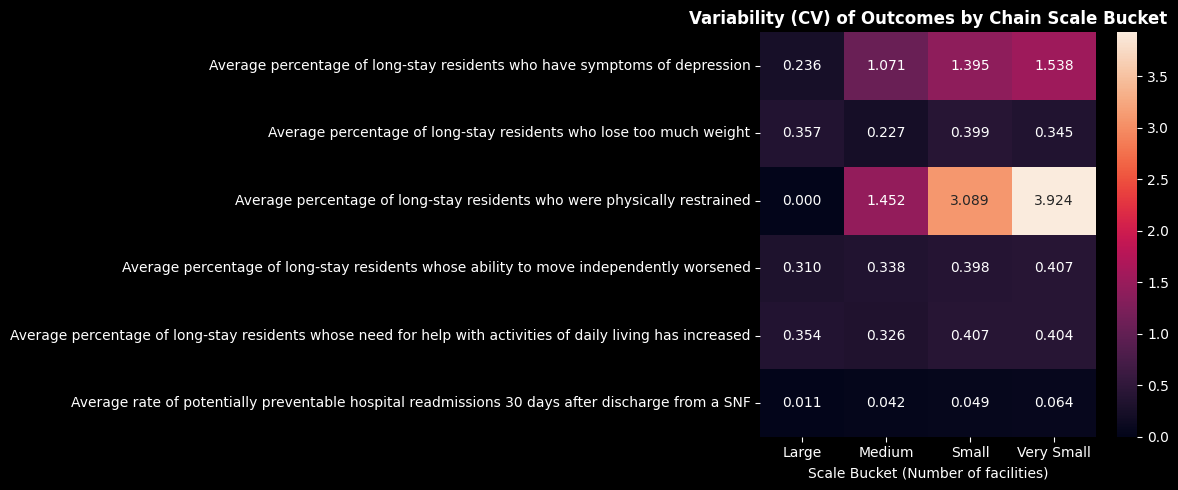

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.heatmap(summary_table, annot=True, fmt=".3f")
plt.title("Variability (CV) of Outcomes by Chain Scale Bucket")
plt.xlabel("Scale Bucket (Number of facilities)")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [19]:
enforcement_cols = [
    "Number of Special Focus Facilities (SFF)",
    "Number of SFF candidates",
    "Percentage of facilities with an abuse icon"
]

for c in enforcement_cols:
    df2[c] = pd.to_numeric(df2[c], errors="coerce")

enforce_by_scale = df2.groupby("scale_bucket")[enforcement_cols].mean().round(3)
enforce_by_scale


/tmp/ipython-input-787194074.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  enforce_by_scale = df2.groupby("scale_bucket")[enforcement_cols].mean().round(3)


,Number of Special Focus Facilities (SFF),Number of SFF candidates,Percentage of facilities with an abuse icon
scale_bucket,,,
Very Small,0.041,0.214,11.129
Small,0.134,0.679,11.554
Medium,0.444,2.148,10.234
Large,3.000,8.667,12.010


In [20]:
ownership_summary = (
    df2
    .groupby(["scale_bucket", "for_profit_dominant"])[core_metrics]
    .mean()
    .round(2)
)

ownership_summary


/tmp/ipython-input-3427878517.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["scale_bucket", "for_profit_dominant"])[core_metrics]


Average percentage of long-stay residents whose ability to move independently worsened  \
scale_bucket for_profit_dominant                                                                                           
Very Small   False                                                            22.31                                        
             True                                                             18.25                                        
Small        False                                                            20.81                                        
             True                                                             16.31                                        
Medium       False                                                            13.77                                        
             True                                                             16.50                                        
Large        False                                                              NaN                                        
             True                                                             17.50                                        

                                  Average percentage of long-stay residents whose need for help with activities of daily living has increased  \
scale_bucket for_profit_dominant                                                                                                                
Very Small   False                                                            18.68                                                             
             True                                                             15.74                                                             
Small        False                                                            17.48                                                             
             True                                                             13.89                                                             
Medium       False                                                            12.80                                                             
             True                                                             13.90                                                             
Large        False                                                              NaN                                                             
             True                                                             14.67                                                             

                                  Average percentage of long-stay residents who were physically restrained  \
scale_bucket for_profit_dominant                                                                             
Very Small   False                                                             0.15                          
             True                                                              0.07                          
Small        False                                                             0.04                          
             True                                                              0.07                          
Medium       False                                                             0.10                          
             True                                                              0.05                          
Large        False                                                              NaN                          
             True                                                              0.10                          

                                  Average percentage of long-stay residents who lose too much weight  \
scale_bucket for_profit_dominant                                                                       
Very Small   False               